In [1]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

/home/mickey/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# this message disables the following outputs:
# INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
# INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
data = pd.read_csv("TFT_prep.csv", parse_dates=["Date"])
data["StockID"] = data["StockID"].astype(str)
#data["quarter"] = data.Date.dt.quarter.astype(str).astype("category")
data["ret_rank"] = data["ret_rank"] - 1
# data["ret_rank"] = data["ret_rank"].astype(str).astype("category")
data.head()


,StockID,quarters_from_start,ibq,ret_rank,Date
0,10006,-8,5.068,0,NaT
1,10006,-7,4.472,0,NaT
2,10006,-6,4.243,0,NaT
3,10006,-5,5.263,0,NaT
4,10006,-4,7.348,0,NaT


In [6]:
training_cutoff = 79 - 1

# Create a complete time index
all_stock_ids = data.StockID.unique()
all_quarters = range(data.quarters_from_start.min(), training_cutoff + 1)

# Create complete index DataFrame
index_df = pd.DataFrame(
    [(stock, quarter) for stock in all_stock_ids for quarter in all_quarters],
    columns=['StockID', 'quarters_from_start']
)

# Merge with original data, fill missing values
complete_data = pd.merge(
    index_df, 
    data, 
    on=['StockID', 'quarters_from_start'], 
    how='left'
)

# Fill missing values using ffill and bfill instead of fillna(method='ffill') and fillna(method='bfill')
complete_data['ibq'] = complete_data.groupby('StockID')['ibq'].transform(
    lambda x: x.ffill().bfill().fillna(0)
)

# For ret_rank, fill with 0
complete_data['ret_rank'] = complete_data['ret_rank'].fillna(0).astype(int)

# Date filling also uses ffill and bfill
complete_data['Date'] = complete_data.groupby('StockID')['Date'].transform(
    lambda x: x.ffill().bfill()
)

# Use filled data
training = TimeSeriesDataSet(
    complete_data[lambda x: x.quarters_from_start <= training_cutoff],
    time_idx="quarters_from_start",
    target="ret_rank",
    group_ids=["StockID"],
    min_encoder_length=8,
    max_encoder_length=8,
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=["StockID"],
    time_varying_known_reals=["quarters_from_start"],
    time_varying_unknown_reals=["ibq"],
    target_normalizer=None,
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_encoder_length=True,
    categorical_encoders={"StockID": NaNLabelEncoder(add_nan = True)}
)

In [7]:
training[0]

({'x_cat': tensor([[1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1]]),
  'x_cont': tensor([[ 1.0000, -1.7123, -1.0000,  0.0694],
          [ 1.0000, -1.6724, -0.8750,  0.0510],
          [ 1.0000, -1.6326, -0.7500,  0.0439],
          [ 1.0000, -1.5928, -0.6250,  0.0754],
          [ 1.0000, -1.5530, -0.5000,  0.1398],
          [ 1.0000, -1.5132, -0.3750,  0.1149],
          [ 1.0000, -1.4733, -0.2500,  0.0733],
          [ 1.0000, -1.4335, -0.1250,  0.1188],
          [ 1.0000, -1.3937,  0.0000,  0.1123]]),
  'encoder_length': 8,
  'decoder_length': 1,
  'encoder_target': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
  'encoder_time_idx_start': tensor(-8),
  'groups': tensor([0]),
  'target_scale': tensor([0., 1.])},
 (tensor([0]), None))

In [8]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    # data[lambda x: x.quarters_from_start <= training_cutoff],
    complete_data,
    #data[data["StockID"].isin(data[lambda x: x.quarters_from_start <= training_cutoff].StockID.unique())],
    predict=True,
    stop_randomization=True,
    # categorical_encoders={"StockID": NaNLabelEncoder(add_nan = True)}
)

In [9]:
print(validation[0])

({'x_cat': tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]), 'x_cont': tensor([[ 1.0000,  1.3937, -1.0000, -0.0871],
        [ 1.0000,  1.4335, -0.8750, -0.0871],
        [ 1.0000,  1.4733, -0.7500, -0.0871],
        [ 1.0000,  1.5132, -0.6250, -0.0871],
        [ 1.0000,  1.5530, -0.5000, -0.0871],
        [ 1.0000,  1.5928, -0.3750, -0.0871],
        [ 1.0000,  1.6326, -0.2500, -0.0871],
        [ 1.0000,  1.6724, -0.1250, -0.0871],
        [ 1.0000,  1.7123,  0.0000, -0.0871]]), 'encoder_length': 8, 'decoder_length': 1, 'encoder_target': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'encoder_time_idx_start': tensor(70), 'groups': tensor([0]), 'target_scale': tensor([0., 1.])}, (tensor([0]), None))


In [10]:
# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=11)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=11, shuffle=False)

In [11]:
for batch in train_dataloader:
    print(batch)
    break

({'encoder_cat': tensor([[[ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999]],

        [[ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667]],

        [[ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680]],

        [[ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373]],

        [[ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995]],

        [[ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013]],

        [[ 4977],
         [ 4977],
         [ 4977],
         [ 4977],
         [ 4977],
         [ 4977],

In [12]:
print(batch)

({'encoder_cat': tensor([[[ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999],
         [ 4999]],

        [[ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667],
         [ 1667]],

        [[ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680],
         [ 2680]],

        [[ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373],
         [ 7373]],

        [[ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995],
         [ 1995]],

        [[ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013],
         [ 4013]],

        [[ 4977],
         [ 4977],
         [ 4977],
         [ 4977],
         [ 4977],
         [ 4977],

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min",)
lr_monitor = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator="gpu",
    # devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_monitor],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=3,
    loss=CrossEntropy(),
    log_interval=0,
    reduce_on_plateau_patience=4,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mickey/myenv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/mickey/myenv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [26]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.1 M  | train
3  | prescalers                         | ModuleDict                      | 1.3 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 104 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 313 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 208 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K  

Epoch 1: 100%|██████████| 13496/13496 [10:51<00:00, 20.71it/s, v_num=13, train_loss_step=0.202, val_loss=0.257, train_loss_epoch=0.189] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 13496/13496 [11:58<00:00, 18.80it/s, v_num=13, train_loss_step=0.202, val_loss=0.257, train_loss_epoch=0.189]


In [28]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_13/checkpoints/epoch=1-step=26992.ckpt


In [29]:
test_data = data[(data["quarters_from_start"]>=73) & (data["quarters_from_start"]<=81)]

In [30]:
test_data

,StockID,quarters_from_start,ibq,ret_rank,Date
81,10010,73,-2.283,0,1992-09-16
82,10010,74,-1.286,2,1992-12-23
83,10010,75,0.727,0,1993-02-24
84,10010,76,0.514,0,1993-06-01
85,10010,77,0.055,0,1993-09-10
...,...,...,...,...,...
507301,93236,77,-0.939,0,NaT
507302,93236,78,-0.834,0,1993-11-19
507303,93236,79,-0.856,0,1994-02-17
507304,93236,80,-1.984,0,1994-06-24


In [38]:
# Make predictions
predictions = best_tft.predict(test_data, mode="raw", return_x=True)

# Convert predictions to probabilities
import torch.nn.functional as F
probabilities = [F.softmax(pred, dim=1) for pred in predictions.output["prediction"]]

/home/mickey/myenv/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1095 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__StockID': '10011'}, {'__group_id__StockID': '10019'}, {'__group_id__StockID': '10075'}, {'__group_id__StockID': '10082'}, {'__group_id__StockID': '10161'}, {'__group_id__StockID': '10192'}, {'__group_id__StockID': '10224'}, {'__group_id__StockID': '10258'}, {'__group_id__StockID': '10281'}, {'__group_id__StockID': '10299'}]
  warnings.warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mickey/myenv/lib/python

In [39]:
# Look at a few probabilities
probabilities[:10]

[tensor([[0.5263, 0.2006, 0.2731]], device='cuda:0'),
 tensor([[0.5099, 0.2296, 0.2605]], device='cuda:0'),
 tensor([[0.3635, 0.3019, 0.3346]], device='cuda:0'),
 tensor([[0.3952, 0.2877, 0.3171]], device='cuda:0'),
 tensor([[0.3311, 0.3042, 0.3647]], device='cuda:0'),
 tensor([[0.3634, 0.2931, 0.3435]], device='cuda:0'),
 tensor([[0.6045, 0.1850, 0.2104]], device='cuda:0'),
 tensor([[0.3444, 0.2934, 0.3623]], device='cuda:0'),
 tensor([[0.9694, 0.0127, 0.0179]], device='cuda:0'),
 tensor([[0.4495, 0.2633, 0.2872]], device='cuda:0')]

In [45]:
# Analyze prediction results
# First, get the index information from the predictions
prediction_index = predictions.x["groups"].cpu().numpy().flatten()

# Create predictions dataframe using only the samples that were predicted
predictions_df = pd.DataFrame()
predictions_df["index"] = prediction_index
predictions_df = predictions_df.merge(
    test_data.reset_index().rename(columns={"index": "original_index"}),
    left_on="index",
    right_on="original_index",
    how="left"
)

In [46]:
# Get prediction probabilities 
prob_array = torch.cat(probabilities, dim=0).cpu().numpy()
predictions_df["prob_class_0"] = prob_array[:, 0]
predictions_df["prob_class_1"] = prob_array[:, 1]
predictions_df["prob_class_2"] = prob_array[:, 2]
predictions_df["predicted"] = np.argmax(prob_array, axis=1)
predictions_df["actual"] = predictions_df["ret_rank"]

In [47]:
# Handle any NaN values
predictions_df = predictions_df.dropna(subset=["actual"])
predictions_df["actual"] = predictions_df["actual"].astype(int)
predictions_df["predicted"] = predictions_df["predicted"].astype(int)

In [48]:
# Print shapes to verify
print(f"Predictions shape: {prob_array.shape}")
print(f"Predictions dataframe shape after removing NaNs: {predictions_df.shape}")
print(f"Original test data shape: {test_data.shape}")

# Calculate accuracy
accuracy = (predictions_df["predicted"] == predictions_df["actual"]).mean()
print(f"Overall accuracy: {accuracy:.4f}")

Predictions shape: (2283, 3)
Predictions dataframe shape after removing NaNs: (208, 12)
Original test data shape: (25680, 5)
Overall accuracy: 0.4760


In [49]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predictions_df["actual"], predictions_df["predicted"])
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[87 15  2]
 [41 11  1]
 [41  9  1]]


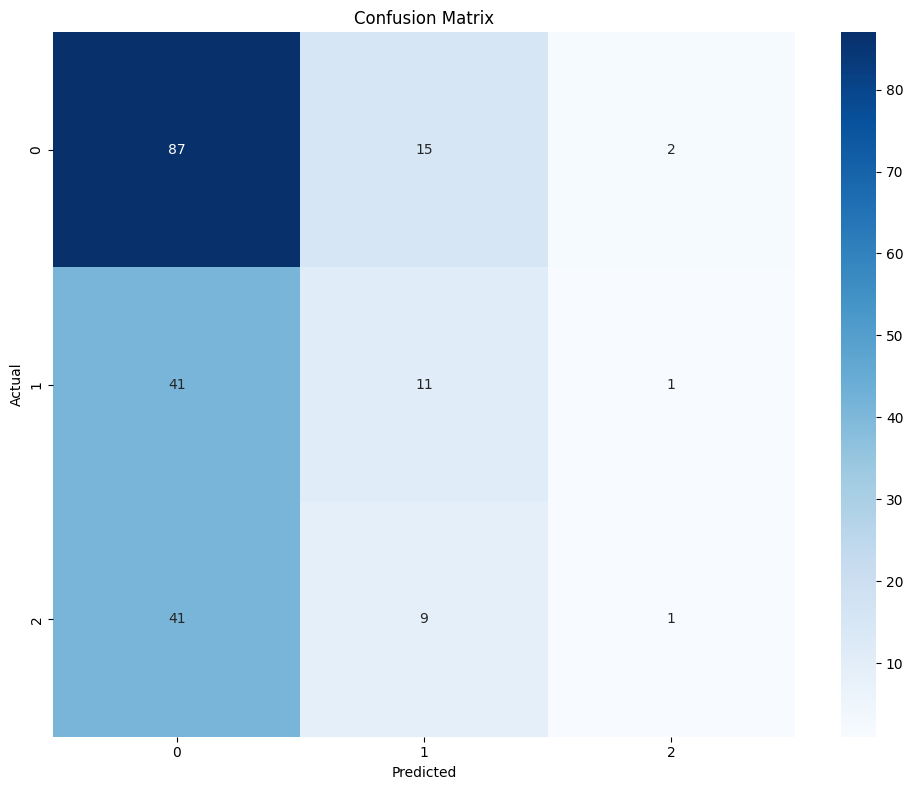

In [50]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.84      0.64       104
           1       0.31      0.21      0.25        53
           2       0.25      0.02      0.04        51

    accuracy                           0.48       208
   macro avg       0.36      0.35      0.31       208
weighted avg       0.40      0.48      0.39       208


Static Variables Importance:


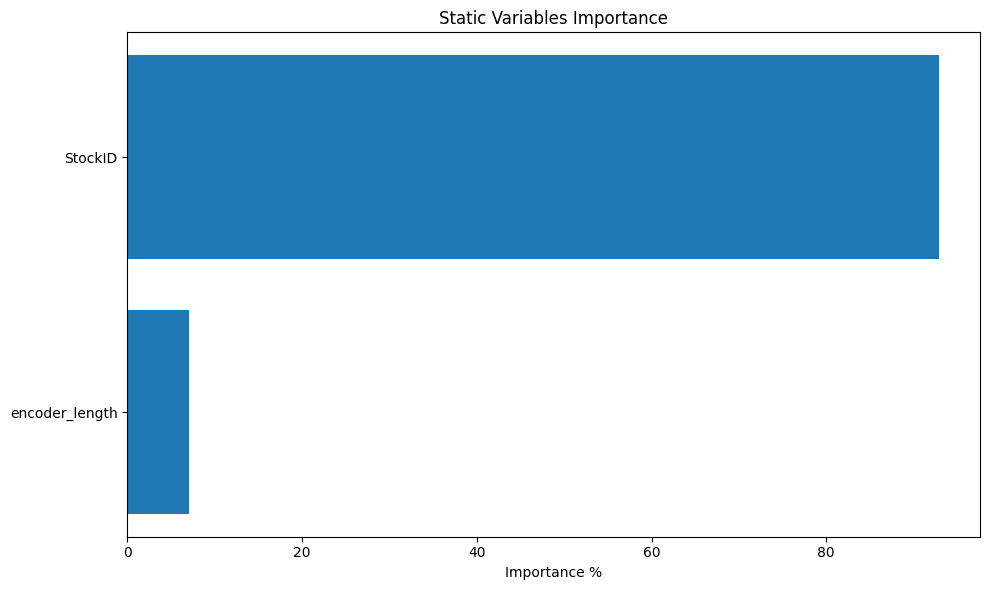


Encoder Variables Importance:


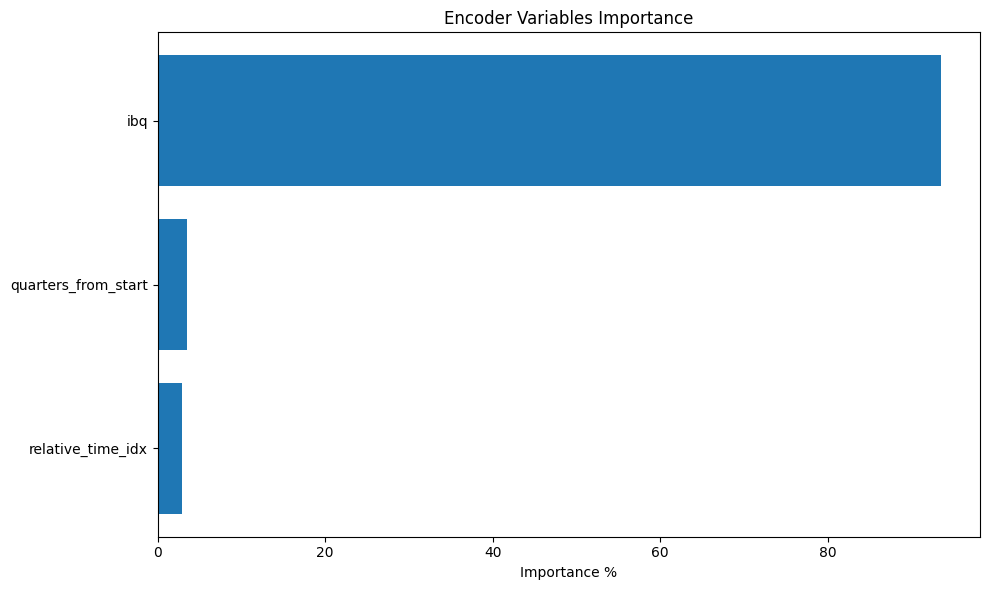


Decoder Variables Importance:


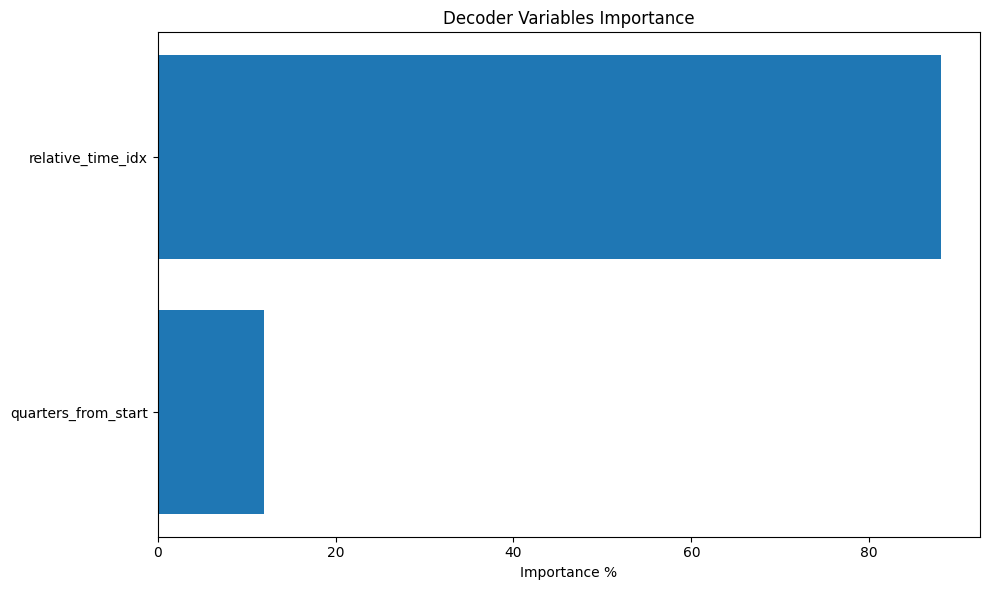

Error in plotting interpretations: Invalid shape () for image data
Let's try a different approach to visualize feature importance:
Alternative approach also failed: 'VariableSelectionNetwork' object has no attribute 'get_selection_weights'
Consider using the raw model weights to analyze feature importance instead.


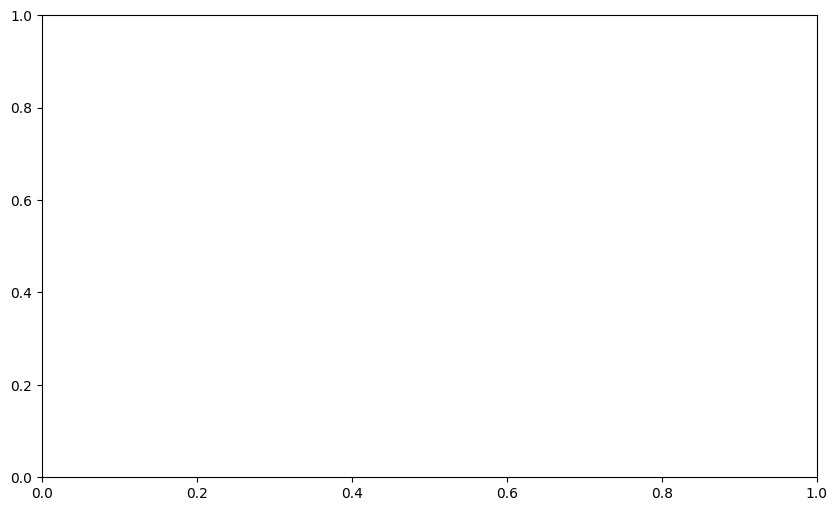

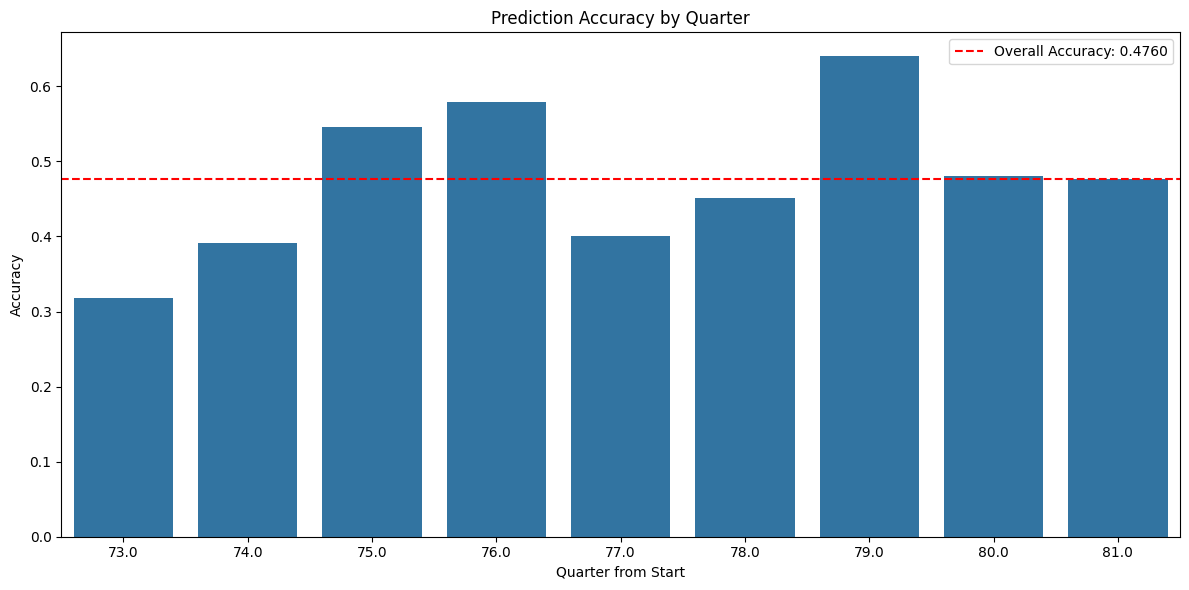

In [52]:
# Print classification report
print("\nClassification Report:")
print(classification_report(predictions_df["actual"], predictions_df["predicted"]))

# To fix the feature importance plotting issue, let's use a more custom approach
# First, get the interpretation outputs
try:
    interpretation = best_tft.interpret_output(predictions.output)
    
    # Function to create a custom importance plot
    def plot_variable_importance(importance_values, variable_names, title):
        plt.figure(figsize=(10, 6))
        # Make sure values are 1D and properly normalized
        if isinstance(importance_values, torch.Tensor):
            importance_values = importance_values.detach().cpu().numpy()
        importance_values = importance_values.reshape(-1)
        
        if len(importance_values) != len(variable_names):
            print(f"Warning: Size mismatch between values ({len(importance_values)}) and labels ({len(variable_names)})")
            # Adjust to match length if needed
            if len(importance_values) > len(variable_names):
                importance_values = importance_values[:len(variable_names)]
            else:
                variable_names = variable_names[:len(importance_values)]
            
        # Calculate percentages
        total = np.sum(importance_values)
        if total > 0:
            importance_pct = (importance_values / total) * 100
        else:
            importance_pct = importance_values * 0
            
        # Sort for better visualization
        sorted_idx = np.argsort(importance_pct)
        sorted_values = importance_pct[sorted_idx]
        sorted_names = [variable_names[i] for i in sorted_idx]
        
        # Create plot
        plt.barh(range(len(sorted_values)), sorted_values, tick_label=sorted_names)
        plt.xlabel("Importance %")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    # Plot static variables importance if available
    if "static_variables" in interpretation and len(best_tft.static_variables) > 0:
        print("\nStatic Variables Importance:")
        plot_variable_importance(
            interpretation["static_variables"], 
            best_tft.static_variables,
            "Static Variables Importance"
        )
    
    # Plot encoder variables importance
    if "encoder_variables" in interpretation and len(best_tft.encoder_variables) > 0:
        print("\nEncoder Variables Importance:")
        plot_variable_importance(
            interpretation["encoder_variables"], 
            best_tft.encoder_variables,
            "Encoder Variables Importance"
        )
    
    # Plot decoder variables importance
    if "decoder_variables" in interpretation and len(best_tft.decoder_variables) > 0:
        print("\nDecoder Variables Importance:")
        plot_variable_importance(
            interpretation["decoder_variables"], 
            best_tft.decoder_variables,
            "Decoder Variables Importance"
        )
        
    # Plot attention if available
    if "attention" in interpretation:
        attention = interpretation["attention"].detach().cpu().numpy()
        plt.figure(figsize=(10, 6))
        plt.imshow(attention[0].mean(0), aspect="auto", cmap="viridis")
        plt.title("Attention Weights")
        plt.ylabel("Decoder time step")
        plt.xlabel("Encoder time step")
        plt.colorbar(label="Attention")
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error in plotting interpretations: {str(e)}")
    print("Let's try a different approach to visualize feature importance:")
    
    # Try to access feature importance directly
    try:
        importance = {
            "StockID": best_tft.static_variable_selection.get_selection_weights().mean(0).detach().cpu().numpy(),
            "quarters_from_start": best_tft.encoder_variable_selection[0].get_selection_weights().mean(0).detach().cpu().numpy()[0],
            "ibq": best_tft.encoder_variable_selection[0].get_selection_weights().mean(0).detach().cpu().numpy()[1]
        }
        
        # Convert to DataFrame for easier plotting
        importance_df = pd.DataFrame([importance], columns=importance.keys())
        importance_df = importance_df.T.reset_index()
        importance_df.columns = ['Feature', 'Importance']
        importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values('Importance'))
        plt.title("Feature Importance")
        plt.xlabel("Relative Importance %")
        plt.tight_layout()
        plt.show()
    except Exception as e2:
        print(f"Alternative approach also failed: {str(e2)}")
        print("Consider using the raw model weights to analyze feature importance instead.")

# Plot accuracy by quarter
plt.figure(figsize=(12, 6))
quarter_accuracy = predictions_df.groupby("quarters_from_start")[["predicted", "actual"]].apply(
    lambda x: (x["predicted"] == x["actual"]).mean()
).reset_index(name="accuracy")

# Calculate overall accuracy for reference line
accuracy = (predictions_df["predicted"] == predictions_df["actual"]).mean()

sns.barplot(x="quarters_from_start", y="accuracy", data=quarter_accuracy)
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
plt.xlabel("Quarter from Start")
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy by Quarter")
plt.legend()
plt.tight_layout()
plt.show()


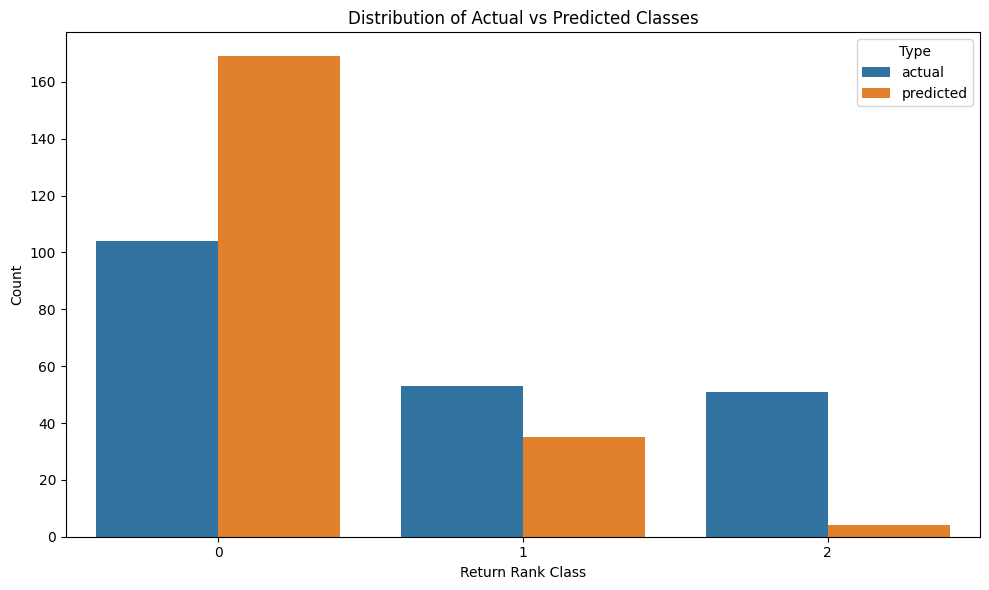

In [53]:
# Plot predicted vs actual distribution
plt.figure(figsize=(10, 6))
predictions_df_melted = pd.melt(predictions_df, 
                               id_vars=['StockID', 'quarters_from_start'], 
                               value_vars=['actual', 'predicted'],
                               var_name='Type', value_name='Class')
sns.countplot(x='Class', hue='Type', data=predictions_df_melted)
plt.xlabel('Return Rank Class')
plt.ylabel('Count')
plt.title('Distribution of Actual vs Predicted Classes')
plt.tight_layout()
plt.show()

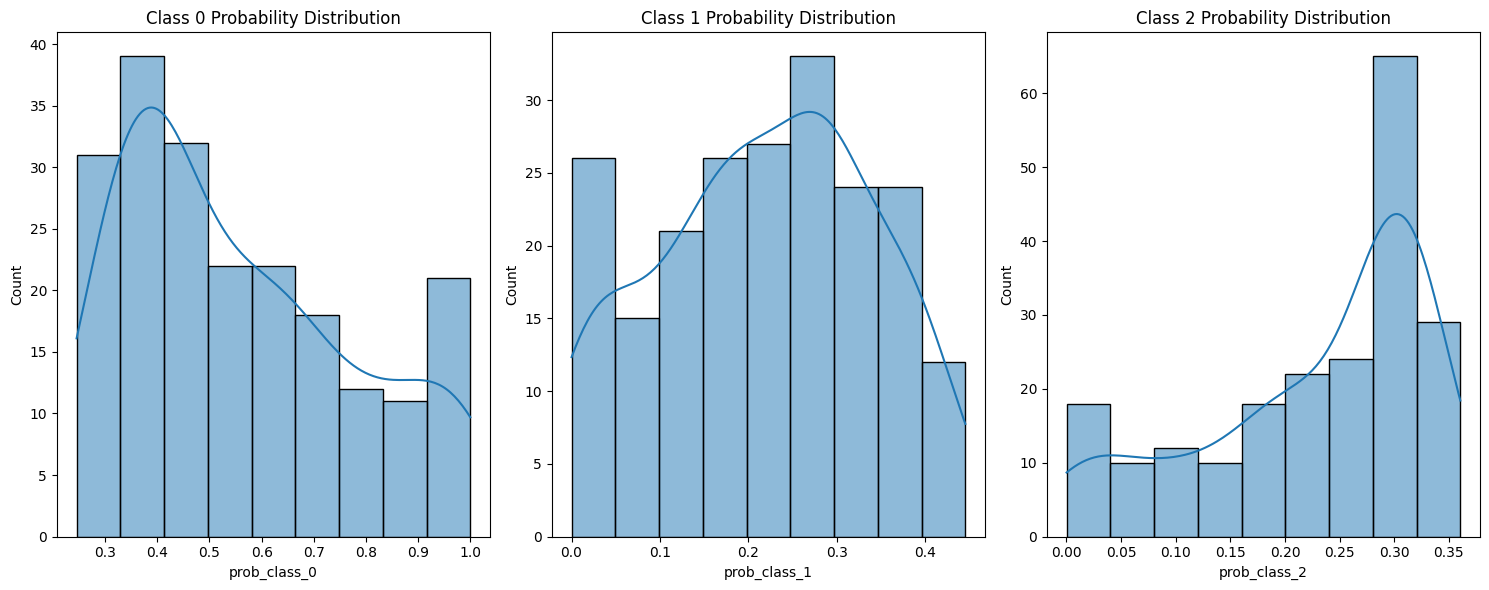

In [54]:
# Plot prediction probability distributions
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.histplot(predictions_df["prob_class_0"], kde=True)
plt.title("Class 0 Probability Distribution")
plt.subplot(1, 3, 2)
sns.histplot(predictions_df["prob_class_1"], kde=True)
plt.title("Class 1 Probability Distribution")
plt.subplot(1, 3, 3)
sns.histplot(predictions_df["prob_class_2"], kde=True)
plt.title("Class 2 Probability Distribution")
plt.tight_layout()
plt.show()

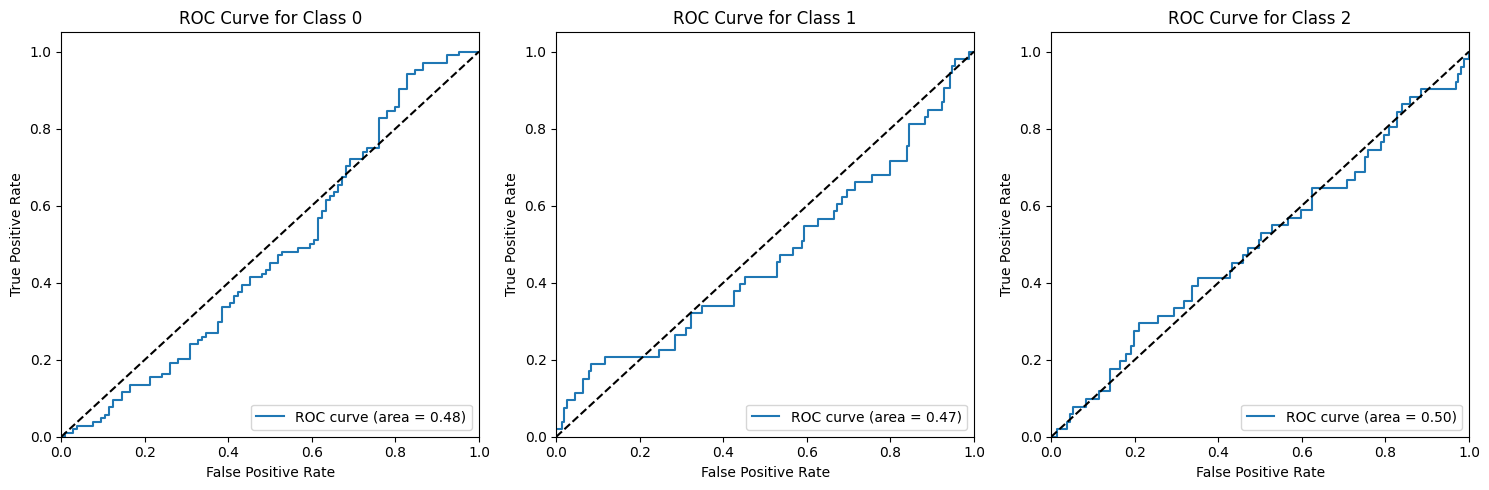

In [55]:
# Plot ROC curves
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(15, 5))

# One-hot encode the actual labels
from sklearn.preprocessing import label_binarize
y_test = label_binarize(predictions_df["actual"], classes=[0, 1, 2])

# Plot ROC curve for each class
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test[:, i], predictions_df[f"prob_class_{i}"])
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 3, i+1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [56]:
# Print a few random examples
import random
sample_indices = random.sample(range(len(predictions_df)), min(10, len(predictions_df)))
sample_df = predictions_df.iloc[sample_indices]
print("\nRandom Prediction Examples:")
print(sample_df[['StockID', 'quarters_from_start', 'actual', 'predicted', 
                 'prob_class_0', 'prob_class_1', 'prob_class_2']])

# Save the model for future use
import os

# Create directory if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")

# Save the model
model_path = "models/tft_stock_returns.pt"
torch.save(best_tft.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Function to load the model
def load_tft_model(model_path, training_dataset):
    # Initialize the model with the same parameters
    model = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=0.001,
        hidden_size=160,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=160,
        output_size=3,
        loss=CrossEntropy(),
        log_interval=0,
        reduce_on_plateau_patience=4,
    )
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    return model

# Create a function for making new predictions
def predict_stock_returns(model, new_data):
    """Make predictions on new data using the trained TFT model"""
    predictions = model.predict(new_data, mode="raw")
    probabilities = torch.softmax(predictions.prediction, dim=2).cpu().numpy()
    predicted_classes = np.argmax(probabilities, axis=2)
    
    results = pd.DataFrame({
        'StockID': new_data['StockID'].values,
        'quarters_from_start': new_data['quarters_from_start'].values,
        'ibq': new_data['ibq'].values,
        'prob_class_0': probabilities[0, :, 0],
        'prob_class_1': probabilities[0, :, 1],
        'prob_class_2': probabilities[0, :, 2],
        'predicted_class': predicted_classes[0]
    })
    
    return results

# Example of how to use the prediction function (commented out)
"""
# Load the model
loaded_model = load_tft_model(model_path, training)

# Prepare new data
new_data = pd.DataFrame({
    'StockID': ['10010', '10010', '10010'],
    'quarters_from_start': [82, 83, 84],
    'ibq': [0.1, 0.2, 0.3],
    'Date': pd.date_range(start='2023-01-01', periods=3, freq='3M')
})

# Make predictions
predictions = predict_stock_returns(loaded_model, new_data)
print(predictions)
"""

print("TFT Stock Return Prediction Model Analysis Complete")



Random Prediction Examples:
     StockID  quarters_from_start  actual  predicted  prob_class_0  \
910    10225                 73.0       1          1      0.292695   
1429   10328                 78.0       2          0      0.429045   
162    10025                 79.0       2          2      0.351073   
499    10154                 75.0       0          1      0.306639   
912    10225                 75.0       0          0      0.362086   
444    10141                 73.0       0          1      0.302385   
1035   10248                 79.0       0          1      0.360680   
1239   10281                 74.0       0          0      0.429841   
534    10163                 80.0       1          1      0.325548   
49     10011                 79.0       0          0      0.999693   

      prob_class_1  prob_class_2  
910       0.378562      0.328743  
1429      0.273865      0.297091  
162       0.293101      0.355826  
499       0.366378      0.326983  
912       0.291337      0